In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, accuracy_score, confusion_matrix

In [1]:
meta_file = f"../datafiles/chexpert/chexpert.sample_128.test.G_filtered_Frontal_nz_500_disc_0.05_sim_5.0_prev_6.0_pred_6.0_cyc_0.csv"

data_dir_race = f"../prediction/chexpert/race/models/densenet-all_128/"
data_dir_sex = f"../prediction/chexpert/sex/pred_only/densenet-128.test.G_{meta_file.split('.G_')[-1].split('.csv')[0]}/"
data_dir_disease = f"../prediction/chexpert/disease/pred_only/densenet-128.test.G_{meta_file.split('.G_')[-1].split('.csv')[0]}/"

# Prediction performance evaluation

In [3]:
df = pd.read_csv(meta_file)

white = "White"
asian = "Asian"
black = "Black"

## Disease classification (multi-label)

In [4]:
cnn_pred_disease = pd.read_csv(data_dir_disease + "predictions.test.csv")

In [5]:
labels = [
    "No Finding",
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Opacity",
    "Lung Lesion",
    "Edema",
    "Consolidation",
    "Pneumonia",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Pleural Other",
    "Fracture",
    "Support Devices",
]

In [6]:
label = 0  # No finding
# label = 10 # Pleural effusion
print(labels[label])

No Finding


In [7]:
cnn_pred_disease["race"] = df["race"]
cnn_pred_disease["sex"] = df["sex"]
cnn_pred_disease["age"] = df["age"]
cnn_pred_disease[labels[label]] = df[labels[label]]

# subgroups
cnn_pred_m = cnn_pred_disease[cnn_pred_disease["sex"] == "Male"].copy()
cnn_pred_f = cnn_pred_disease[cnn_pred_disease["sex"] == "Female"].copy()
cnn_pred_w = cnn_pred_disease[cnn_pred_disease["race"] == white].copy()
cnn_pred_a = cnn_pred_disease[cnn_pred_disease["race"] == asian].copy()
cnn_pred_b = cnn_pred_disease[cnn_pred_disease["race"] == black].copy()

In [8]:
preds = cnn_pred_disease["class_" + str(label)]
targets = np.array(cnn_pred_disease["target_" + str(label)])

preds_m = cnn_pred_m["class_" + str(label)]
targets_m = np.array(cnn_pred_m["target_" + str(label)])

preds_f = cnn_pred_f["class_" + str(label)]
targets_f = np.array(cnn_pred_f["target_" + str(label)])

preds_w = cnn_pred_w["class_" + str(label)]
targets_w = np.array(cnn_pred_w["target_" + str(label)])

preds_a = cnn_pred_a["class_" + str(label)]
targets_a = np.array(cnn_pred_a["target_" + str(label)])

preds_b = cnn_pred_b["class_" + str(label)]
targets_b = np.array(cnn_pred_b["target_" + str(label)])

In [9]:
aucs = [
    round(
        roc_auc_score(
            cnn_pred_disease["target_" + str(i)], cnn_pred_disease["class_" + str(i)]
        ),
        4,
    )
    if cnn_pred_disease["target_" + str(i)].sum() != 0
    else np.nan
    for i in range(14)
]
aucs_l = {l: a for l, a in zip(labels, aucs)}
myKeys = list(aucs_l.keys())
myKeys.sort()
aucs_l = {i: aucs_l[i] for i in myKeys}
print(f"ALL AUC: {aucs_l}")
print(f"ALL AUC average: {round(np.nanmean(aucs),4)}")

ALL AUC: {'Atelectasis': 0.5835, 'Cardiomegaly': 0.7173, 'Consolidation': 0.6295, 'Edema': 0.7401, 'Enlarged Cardiomediastinum': 0.5954, 'Fracture': 0.6145, 'Lung Lesion': 0.6618, 'Lung Opacity': 0.6242, 'No Finding': 0.7629, 'Pleural Effusion': 0.7075, 'Pleural Other': 0.708, 'Pneumonia': 0.5836, 'Pneumothorax': 0.6152, 'Support Devices': 0.5949}
ALL AUC average: 0.6527


In [10]:
target_fpr = 0.2

fpr, tpr, thres = roc_curve(targets, preds)
fpr_w, tpr_w, thres_w = roc_curve(targets_w, preds_w)
fpr_a, tpr_a, thres_a = roc_curve(targets_a, preds_a)
fpr_b, tpr_b, thres_b = roc_curve(targets_b, preds_b)
fpr_m, tpr_m, thres_m = roc_curve(targets_m, preds_m)
fpr_f, tpr_f, thres_f = roc_curve(targets_f, preds_f)

roc_auc = auc(fpr, tpr)
roc_auc_w = auc(fpr_w, tpr_w)
roc_auc_a = auc(fpr_a, tpr_a)
roc_auc_b = auc(fpr_b, tpr_b)
roc_auc_m = auc(fpr_m, tpr_m)
roc_auc_f = auc(fpr_f, tpr_f)

# global threshold
op = thres[np.argmin(np.abs(fpr - target_fpr))]

print("All \t Threshold %0.4f" % op)

All 	 Threshold 0.0476


In [11]:
# APPLYING GLOBAL THRESHOLD
fpr_t = 1 - recall_score(targets, preds >= op, pos_label=0)
tpr_t = recall_score(targets, preds >= op, pos_label=1)

fpr_t_w = 1 - recall_score(targets_w, preds_w >= op, pos_label=0)
tpr_t_w = recall_score(targets_w, preds_w >= op, pos_label=1)

fpr_t_a = 1 - recall_score(targets_a, preds_a >= op, pos_label=0)
tpr_t_a = recall_score(targets_a, preds_a >= op, pos_label=1)

fpr_t_b = 1 - recall_score(targets_b, preds_b >= op, pos_label=0)
tpr_t_b = recall_score(targets_b, preds_b >= op, pos_label=1)

fpr_t_f = 1 - recall_score(targets_f, preds_f >= op, pos_label=0)
tpr_t_f = recall_score(targets_f, preds_f >= op, pos_label=1)

fpr_t_m = 1 - recall_score(targets_m, preds_m >= op, pos_label=0)
tpr_t_m = recall_score(targets_m, preds_m >= op, pos_label=1)

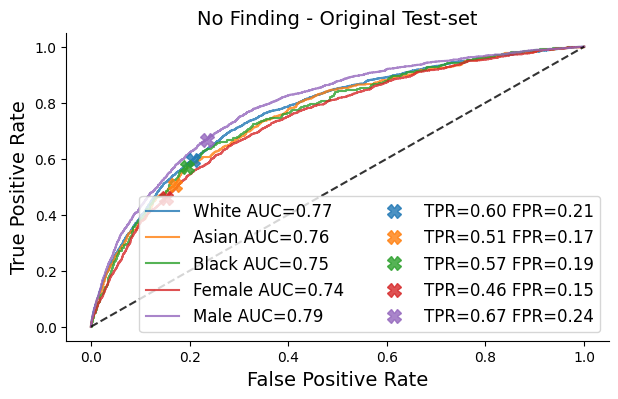

All	TPR 0.58 | FPR 0.20 | AUC 0.76
White	TPR 0.60 | FPR 0.21 | AUC 0.77
Asian	TPR 0.51 | FPR 0.17 | AUC 0.76
Black	TPR 0.57 | FPR 0.19 | AUC 0.75
Female	TPR 0.46 | FPR 0.15 | AUC 0.74
Male	TPR 0.67 | FPR 0.24 | AUC 0.79


In [12]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=0.8, label="White AUC=%0.2f" % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=0.8, label="Asian AUC=%0.2f" % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=0.8, label="Black AUC=%0.2f" % roc_auc_b)
plt.plot(fpr_f, tpr_f, lw=1.5, alpha=0.8, label="Female AUC=%0.2f" % roc_auc_f)
plt.plot(fpr_m, tpr_m, lw=1.5, alpha=0.8, label="Male AUC=%0.2f" % roc_auc_m)

plt.gca().set_prop_cycle(None)

plt.plot(
    fpr_t_w,
    tpr_t_w,
    "X",
    alpha=0.8,
    markersize=10,
    label="TPR=%0.2f FPR=%0.2f" % (tpr_t_w, fpr_t_w),
)
plt.plot(
    fpr_t_a,
    tpr_t_a,
    "X",
    alpha=0.8,
    markersize=10,
    label="TPR=%0.2f FPR=%0.2f" % (tpr_t_a, fpr_t_a),
)
plt.plot(
    fpr_t_b,
    tpr_t_b,
    "X",
    alpha=0.8,
    markersize=10,
    label="TPR=%0.2f FPR=%0.2f" % (tpr_t_b, fpr_t_b),
)
plt.plot(
    fpr_t_f,
    tpr_t_f,
    "X",
    alpha=0.8,
    markersize=10,
    label="TPR=%0.2f FPR=%0.2f" % (tpr_t_f, fpr_t_f),
)
plt.plot(
    fpr_t_m,
    tpr_t_m,
    "X",
    alpha=0.8,
    markersize=10,
    label="TPR=%0.2f FPR=%0.2f" % (tpr_t_m, fpr_t_m),
)

plt.legend(loc="lower right", fontsize=12, ncol=2)
title = labels[label] + " - Original Test-set"
ax.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="k", label="Chance", alpha=0.8)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title(title, fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[["right", "top"]].set_visible(False)
plt.show()
# fig.savefig(title + '.png', bbox_inches='tight', dpi=300)

print("All\tTPR %0.2f | FPR %0.2f | AUC %0.2f" % (tpr_t, fpr_t, roc_auc))
print("White\tTPR %0.2f | FPR %0.2f | AUC %0.2f" % (tpr_t_w, fpr_t_w, roc_auc_w))
print("Asian\tTPR %0.2f | FPR %0.2f | AUC %0.2f" % (tpr_t_a, fpr_t_a, roc_auc_a))
print("Black\tTPR %0.2f | FPR %0.2f | AUC %0.2f" % (tpr_t_b, fpr_t_b, roc_auc_b))
print("Female\tTPR %0.2f | FPR %0.2f | AUC %0.2f" % (tpr_t_f, fpr_t_f, roc_auc_f))
print("Male\tTPR %0.2f | FPR %0.2f | AUC %0.2f" % (tpr_t_m, fpr_t_m, roc_auc_m))

## Race classification

In [4]:
cnn_pred_race = pd.read_csv(data_dir_race + "predictions.test.csv")

In [5]:
preds_race = np.stack(
    [cnn_pred_race["class_0"], cnn_pred_race["class_1"], cnn_pred_race["class_2"]]
).transpose()
targets_race = np.array(cnn_pred_race["target"])

In [6]:
[round(i, 3) for i in np.mean(preds_race, axis=0)]

[0.806, 0.098, 0.096]

In [32]:
y_true = targets_race
y_pred = np.argmax(preds_race, axis=1)
matrix = confusion_matrix(y_true, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.96421391, 0.53115044, 0.64712309])

In [33]:
print("Random guessing")
[round(np.sum(targets_race==i)/len(targets_race),4) for i in range(3)]

Random guessing


[0.7804, 0.1478, 0.0718]

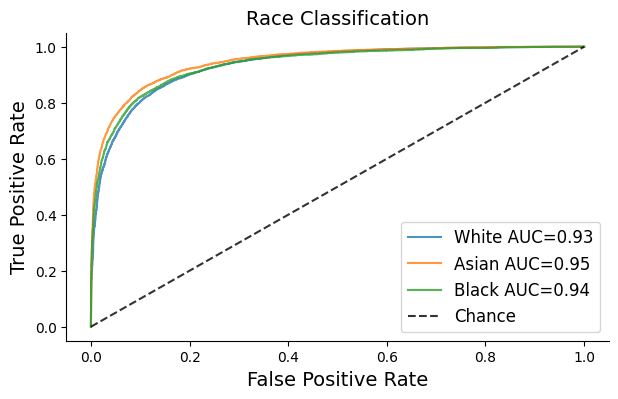

In [7]:
# WHITE
pos_label = 0
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_w, tpr_w, _ = roc_curve(y, preds_race[:, pos_label])
roc_auc_w = auc(fpr_w, tpr_w)

# ASIAN
pos_label = 1
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_a, tpr_a, _ = roc_curve(y, preds_race[:, pos_label])
roc_auc_a = auc(fpr_a, tpr_a)

# BLACK
pos_label = 2
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_b, tpr_b, _ = roc_curve(y, preds_race[:, pos_label])
roc_auc_b = auc(fpr_b, tpr_b)

fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=0.8, label="White AUC=%0.2f" % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=0.8, label="Asian AUC=%0.2f" % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=0.8, label="Black AUC=%0.2f" % roc_auc_b)
ax.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="k", label="Chance", alpha=0.8)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title("Race Classification", fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[["right", "top"]].set_visible(False)
plt.show()

# fig.savefig("CNN-race.png", bbox_inches='tight', dpi=300)

## Sex classification

In [ ]:
cnn_pred_sex = pd.read_csv(data_dir_sex + "predictions.test.csv")

# for subgroup analysis
cnn_pred_sex["race"] = df["race"]
cnn_pred_sex_w = cnn_pred_sex[cnn_pred_sex["race"] == white]
cnn_pred_sex_a = cnn_pred_sex[cnn_pred_sex["race"] == asian]
cnn_pred_sex_b = cnn_pred_sex[cnn_pred_sex["race"] == black]

In [ ]:
preds_sex = np.stack([cnn_pred_sex_w["class_0"], cnn_pred_sex_w["class_1"]]).transpose()
targets_sex = np.array(cnn_pred_sex_w["target"])
fpr_w, tpr_w, _ = roc_curve(targets_sex, preds_sex[:, 1])
roc_auc_w = auc(fpr_w, tpr_w)

preds_sex = np.stack([cnn_pred_sex_a["class_0"], cnn_pred_sex_a["class_1"]]).transpose()
targets_sex = np.array(cnn_pred_sex_a["target"])
fpr_a, tpr_a, _ = roc_curve(targets_sex, preds_sex[:, 1])
roc_auc_a = auc(fpr_a, tpr_a)

preds_sex = np.stack([cnn_pred_sex_b["class_0"], cnn_pred_sex_b["class_1"]]).transpose()
targets_sex = np.array(cnn_pred_sex_b["target"])
fpr_b, tpr_b, _ = roc_curve(targets_sex, preds_sex[:, 1])
roc_auc_b = auc(fpr_b, tpr_b)

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=0.8, label="White AUC=%0.2f" % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=0.8, label="Asian AUC=%0.2f" % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=0.8, label="Black AUC=%0.2f" % roc_auc_b)
ax.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="k", label="Chance", alpha=0.8)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title("Sex Classification", fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[["right", "top"]].set_visible(False)
# fig.savefig("CNN-sex.png", bbox_inches='tight', dpi=300)